<a href="https://colab.research.google.com/github/caiogasparine/SCS_3253_061-Machine-Learning/blob/main/Toronto_Police_Major_Crime_Indicators_MCI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Source of Data: Major Crime Indicators (MCI) Historical**

This dataset includes all Major Crime Indicators (MCI) occurrences by reported date and related offences from 2014 to June 30, 2022.

https://data.torontopolice.on.ca/pages/major-crime-indicators


# 1 - Big Picture / Frame the problem 
University of Toronto
SCS 3253-061 - Machine Learning // Instructor: Saeid Abolfazli

**Group Members:**
*   Caio Gasparine
*   Fabio Queiroz
*   Olivier Sangam
*   Illidan Yuan

# 2 - Get the data / Develop the pipeline

Data profiling was done to ensure data quality and integrity. Contents of each field were analyzed for any anomalies and Null values. None we found.

In [341]:
### Toronto Police / MCI indicators
### Created on February 21, 2023 / Last update April 5th, 2023
### Important assumptions: occurrenceyear will be used to base all the statistics and evaluations (reportedyear)
### This is to reflect WHEN the event really happened 

### Loading the main used libraries
from datetime import date
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import warnings                    #These 2 lines remove all the warnigns in the code  
warnings.filterwarnings("ignore")  #These 2 lines remove all the warnigns in the code  
%matplotlib inline
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score

from google.colab import drive
from google.colab import data_table        #Mar 16, 2023 - Interactive Tables for DataFrames 
data_table.enable_dataframe_formatter()    #Mar 16, 2023 - Interactive Tables for Dataframes 

In [342]:
### Change the code here, depending on your dataset location
### data = pd.read_csv('Major_Crime_Indicators.csv', header=0)
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Major_Crime_Indicators.csv', header=0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [343]:
### Defining our scope (Assumption) considering years with complete data 2014 to 2021 // March 7, 2023
### ocurrencedate min = 9/6/1966 and year = NULL AND ocurrencedata max = 30/06/2022
### Cleaning the dataset to have the full data for a complete year 2014-2021
data = data[(data.mci_category=='Theft Over')]     ### Limiting number of records to be processed
data = data[data.occurrenceyear >=2014]
data = data[data.occurrenceyear <=2021]
data = data.drop(columns=['X', 'Y', 'Index_', 'event_unique_id', 'reporteddate', 'reporteddayofyear', 'reportedyear', 'reporteddayofweek', 'reportedmonth', 'reportedday', 'reportedhour', 'occurrencedayofyear' ])

# 3 - Explore and visualize the data to gain insights + Cleaning


In [344]:
### Exploring the data to gain insigths // (lines, colunms) OR (instances, features) 
data.shape

(281153, 18)

In [345]:
### Exploring the data to gain insigths // visualizing all the columns available 
data.columns

Index(['Division', 'occurrencedate', 'location_type', 'premises_type',
       'ucr_code', 'ucr_ext', 'offence', 'occurrenceyear', 'occurrencemonth',
       'occurrenceday', 'occurrencedayofweek', 'occurrencehour',
       'mci_category', 'Hood_ID', 'Neighbourhood', 'Longitude', 'Latitude',
       'ObjectId'],
      dtype='object')

In [346]:
### Exploring the data to gain insigths // visualizing the data - 5 first instances
data.head(5)

,Division,occurrencedate,location_type,premises_type,ucr_code,ucr_ext,offence,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofweek,occurrencehour,mci_category,Hood_ID,Neighbourhood,Longitude,Latitude,ObjectId
0,D31,2014/01/03 05:00:00+00,"Apartment (Rooming House, Condo)",Apartment,1430,100,Assault,2014.0,January,3.0,Friday,11,Assault,27,York University Heights,-79.504475,43.766371,1
1,D42,2014/01/03 05:00:00+00,"Single Home, House (Attach Garage, Cottage, Mo...",House,2120,200,B&E,2014.0,January,3.0,Friday,14,Break and Enter,132,Malvern,-79.217083,43.814861,2
2,D22,2014/01/03 05:00:00+00,"Open Areas (Lakes, Parks, Rivers)",Outside,1430,100,Assault,2014.0,January,3.0,Friday,13,Assault,19,Long Branch,-79.534957,43.589085,3
3,D53,2014/01/03 05:00:00+00,Other Commercial / Corporate Places (For Profi...,Commercial,2130,210,Theft Over,2014.0,January,3.0,Friday,12,Theft Over,55,Thorncliffe Park,-79.346588,43.703212,4
4,D22,2014/01/03 05:00:00+00,Convenience Stores,Commercial,1610,210,Robbery - Business,2014.0,January,3.0,Friday,14,Robbery,14,Islington-City Centre West,-79.531916,43.645247,5


In [347]:
### Exploring the data to gain insigths // visualizing the data - 5 last instances
data.tail(5)

,Division,occurrencedate,location_type,premises_type,ucr_code,ucr_ext,offence,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofweek,occurrencehour,mci_category,Hood_ID,Neighbourhood,Longitude,Latitude,ObjectId
301181,D53,2021/01/01 05:00:00+00,"Single Home, House (Attach Garage, Cottage, Mo...",House,1430,100,Assault,2021.0,January,1.0,Friday,18,Assault,56,Leaside-Bennington,-79.372779,43.717185,301182
301183,D41,2021/05/30 04:00:00+00,Ttc Subway Station,Transit,1430,100,Assault,2021.0,May,30.0,Sunday,0,Assault,120,Clairlea-Birchmount,-79.280963,43.712045,301184
301193,D12,2021/06/01 04:00:00+00,"Single Home, House (Attach Garage, Cottage, Mo...",House,1430,100,Assault,2021.0,June,1.0,Tuesday,0,Assault,29,Maple Leaf,-79.482170,43.710613,301194
301201,D41,2021/10/28 04:00:00+00,"Single Home, House (Attach Garage, Cottage, Mo...",House,2120,200,B&E,2021.0,October,28.0,Thursday,15,Break and Enter,123,Cliffcrest,-79.245055,43.706719,301202
301205,D31,2021/05/30 04:00:00+00,"Single Home, House (Attach Garage, Cottage, Mo...",House,1430,100,Assault,2021.0,May,30.0,Sunday,0,Assault,26,Downsview-Roding-CFB,-79.476408,43.725396,301206


In [348]:
### Exploring the data to gain insigths // additional infor about your data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281153 entries, 0 to 301205
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Division             281153 non-null  object 
 1   occurrencedate       281153 non-null  object 
 2   location_type        281153 non-null  object 
 3   premises_type        281153 non-null  object 
 4   ucr_code             281153 non-null  int64  
 5   ucr_ext              281153 non-null  int64  
 6   offence              281153 non-null  object 
 7   occurrenceyear       281153 non-null  float64
 8   occurrencemonth      281153 non-null  object 
 9   occurrenceday        281153 non-null  float64
 10  occurrencedayofweek  281153 non-null  object 
 11  occurrencehour       281153 non-null  int64  
 12  mci_category         281153 non-null  object 
 13  Hood_ID              281153 non-null  object 
 14  Neighbourhood        281153 non-null  object 
 15  Longitude        

In [349]:
### Exploring the data to gain insigths // Looking for null value on the dataset
data.isna().sum()

Division               0
occurrencedate         0
location_type          0
premises_type          0
ucr_code               0
ucr_ext                0
offence                0
occurrenceyear         0
occurrencemonth        0
occurrenceday          0
occurrencedayofweek    0
occurrencehour         0
mci_category           0
Hood_ID                0
Neighbourhood          0
Longitude              0
Latitude               0
ObjectId               0
dtype: int64

In [350]:
### Exploring the data to gain insigths // Looking for duplicated values
data.loc[data.duplicated()]

,Division,occurrencedate,location_type,premises_type,ucr_code,ucr_ext,offence,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofweek,occurrencehour,mci_category,Hood_ID,Neighbourhood,Longitude,Latitude,ObjectId


In [351]:
### Exploring the data to gain insigths // count of values for a specific column/feature
data['mci_category'].value_counts()

Assault            151290
Break and Enter     56446
Auto Theft          36415
Robbery             27786
Theft Over           9216
Name: mci_category, dtype: int64

In [352]:
### Exploring the data to gain insigths // count of values for a specific column/feature
data['location_type'].value_counts()

Apartment (Rooming House, Condo)                                          67263
Single Home, House (Attach Garage, Cottage, Mobile)                       50460
Streets, Roads, Highways (Bicycle Path, Private Road)                     44757
Other Commercial / Corporate Places (For Profit, Warehouse, Corp. Bldg    32460
Parking Lots (Apt., Commercial Or Non-Commercial)                         23310
Bar / Restaurant                                                          11324
Open Areas (Lakes, Parks, Rivers)                                          6022
Schools During Supervised Activity                                         4321
Convenience Stores                                                         3598
Ttc Subway Station                                                         3316
Commercial Dwelling Unit (Hotel, Motel, B & B, Short Term Rental)          3256
Schools During Un-Supervised Activity                                      2512
Hospital / Institutions / Medical Facili

In [353]:
### Exploring the data to gain insigths // count of values for a specific column/feature
data['ucr_code'].value_counts()

1430    103638
2120     56422
2135     36415
1420     31875
1610     27785
2130      6496
1460      4959
1480      3322
1450      3263
1410      2385
2132      2261
1457      1037
1461       506
2133       459
1455       168
1470       100
1462        22
1440        13
2125        13
2121        11
1475         2
1611         1
Name: ucr_code, dtype: int64

In [354]:
### Exploring the data to gain insigths // count of values for a specific column/feature
data['premises_type'].value_counts()

Outside        74890
Apartment      67263
Commercial     56924
House          50460
Other          16367
Transit         7887
Educational     7362
Name: premises_type, dtype: int64

In [355]:
### Exploring the data to gain insigths // count of values for a specific column/feature
data['offence'].value_counts()

Assault                           103291
B&E                                47650
Theft Of Motor Vehicle             36415
Assault With Weapon                25223
Robbery - Mugging                   8149
B&E W'Intent                        6973
Assault Bodily Harm                 6652
Theft Over                          5112
Assault Peace Officer               4855
Robbery - Other                     4609
Robbery With Weapon                 4538
Robbery - Business                  3975
Assault - Resist/ Prevent Seiz      2894
Aggravated Assault                  2366
Theft From Motor Vehicle Over       2261
Robbery - Swarming                  2239
Discharge Firearm With Intent       1912
Unlawfully In Dwelling-House        1701
Discharge Firearm - Recklessly      1326
Theft From Mail / Bag / Key         1116
Robbery - Home Invasion             1074
Pointing A Firearm                  1037
Robbery - Purse Snatch              1011
Robbery - Financial Institute        860
Robbery - Vehicl

In [356]:
### Exploring the data to gain insigths // count of values for a specific column/feature
data['Neighbourhood'].value_counts()

Waterfront Communities-The Island    10473
Church-Yonge Corridor                 9331
Bay Street Corridor                   8062
West Humber-Clairville                7496
Moss Park                             6853
                                     ...  
Yonge-St.Clair                         546
Guildwood                              527
Maple Leaf                             503
Woodbine-Lumsden                       498
Lambton Baby Point                     427
Name: Neighbourhood, Length: 141, dtype: int64

In [357]:
### Exploring the data to gain insigths // Descriptive statistics that summarizes the central tendency, dispersion and shape 
### of a dataset’s distribution, excluding NaN values for all columns/features
data.describe()

,ucr_code,ucr_ext,occurrenceyear,occurrenceday,occurrencehour,Longitude,Latitude,ObjectId
count,281153.000000,281153.000000,281153.000000,281153.000000,281153.000000,281153.000000,281153.000000,281153.000000
mean,1700.832821,146.402578,2017.578162,15.492689,12.618443,-78.385004,43.150238,141582.294171
std,325.535649,51.917990,2.250533,8.904309,7.232738,8.903849,4.901440,81453.182017
min,1410.000000,100.000000,2014.000000,1.000000,0.000000,-80.042866,0.000000,1.000000
25%,1430.000000,100.000000,2016.000000,8.000000,7.000000,-79.470606,43.659859,71137.000000
50%,1450.000000,100.000000,2018.000000,16.000000,14.000000,-79.392819,43.699278,141567.000000
75%,2120.000000,200.000000,2019.000000,23.000000,19.000000,-79.319201,43.751025,212067.000000
max,2135.000000,230.000000,2021.000000,31.000000,23.000000,0.000000,44.333691,301206.000000


In [358]:
### Exploring the data to gain insigths // count of values for a specific column/feature
data['occurrenceyear'].value_counts()

2019.0    39967
2018.0    37440
2017.0    35501
2020.0    34973
2021.0    34277
2016.0    33608
2015.0    32920
2014.0    32467
Name: occurrenceyear, dtype: int64

In [359]:
### Exploring the data to gain insigths / Check if any column has missing values ("False" = not missing - "True" = missing)
data.isnull().any()

Division               False
occurrencedate         False
location_type          False
premises_type          False
ucr_code               False
ucr_ext                False
offence                False
occurrenceyear         False
occurrencemonth        False
occurrenceday          False
occurrencedayofweek    False
occurrencehour         False
mci_category           False
Hood_ID                False
Neighbourhood          False
Longitude              False
Latitude               False
ObjectId               False
dtype: bool

In [360]:
### Exploring the data to gain insigths / Visualizing data from specfic columns/features
data[['mci_category','offence','ucr_ext']]

,mci_category,offence,ucr_ext
0,Assault,Assault,100
1,Break and Enter,B&E,200
2,Assault,Assault,100
3,Theft Over,Theft Over,210
4,Robbery,Robbery - Business,210
...,...,...,...
301181,Assault,Assault,100
301183,Assault,Assault,100
301193,Assault,Assault,100
301201,Break and Enter,B&E,200


In [361]:
### Exploring the data to gain insigths // count of values for a specific column/feature
data["mci_category"].value_counts()

Assault            151290
Break and Enter     56446
Auto Theft          36415
Robbery             27786
Theft Over           9216
Name: mci_category, dtype: int64

In [362]:
### Exploring the data to gain insigths // Descriptive statistics that summarizes the central tendency, dispersion and shape 
### of a dataset’s distribution, excluding NaN values for selected columns/features
data[0:-1].describe()

,ucr_code,ucr_ext,occurrenceyear,occurrenceday,occurrencehour,Longitude,Latitude,ObjectId
count,281152.000000,281152.000000,281152.000000,281152.000000,281152.000000,281152.000000,281152.000000,281152.000000
mean,1700.833784,146.402743,2017.578150,15.492637,12.618488,-78.385001,43.150236,141581.726422
std,325.535828,51.918008,2.250528,8.904283,7.232712,8.903864,4.901449,81452.770560
min,1410.000000,100.000000,2014.000000,1.000000,0.000000,-80.042866,0.000000,1.000000
25%,1430.000000,100.000000,2016.000000,8.000000,7.000000,-79.470606,43.659859,71136.750000
50%,1450.000000,100.000000,2018.000000,16.000000,14.000000,-79.392819,43.699278,141566.500000
75%,2120.000000,200.000000,2019.000000,23.000000,19.000000,-79.319201,43.751025,212066.250000
max,2135.000000,230.000000,2021.000000,31.000000,23.000000,0.000000,44.333691,301202.000000


In [363]:
### Exploring the data to gain insigths
### Using pandas crosstab // Feb 24, 2023
data_ct = pd.crosstab(data.mci_category, data.occurrenceyear, margins=True)
data_ct

occurrenceyear,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,All
mci_category,,,,,,,,,
Assault,16820,18128,19009,19631,19919,20932,18180,18671,151290
Auto Theft,3645,3265,3346,3654,4829,5369,5766,6541,36415
Break and Enter,7231,6939,6435,6938,7652,8574,6960,5717,56446
Robbery,3757,3545,3776,4092,3755,3723,2858,2280,27786
Theft Over,1014,1043,1042,1186,1285,1369,1209,1068,9216
All,32467,32920,33608,35501,37440,39967,34973,34277,281153


Text(0.5, 1.0, 'MCI Type by occurrenceyear')

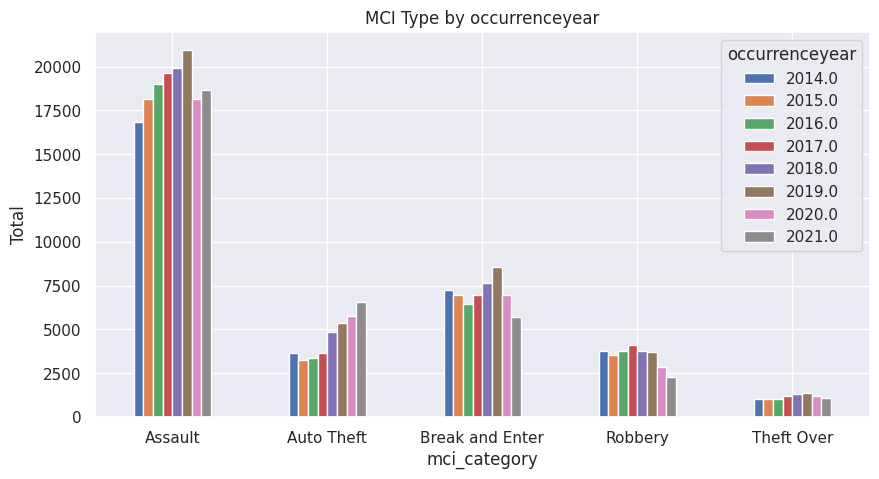

In [364]:
### Exploring the data to gain insigths
### Using pandas crosstab // Feb 24, 2023
data_ct_plot = pd.crosstab(data.mci_category, data.occurrenceyear)
data_ct_plot.plot(kind='bar', stacked=False, rot = 0, figsize=(10, 5));
plt.ylabel('Total')
plt.title('MCI Type by occurrenceyear')

In [365]:
### Exploring the data to gain insigths
### Describe from data_crosstable // Feb 27,2023
data_ct[0:-1].describe()

occurrenceyear,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,All
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000
mean,6493.400000,6584.000000,6721.600000,7100.200000,7488.000000,7993.400000,6994.600000,6855.400000,56230.60000
std,6180.772872,6788.665627,7130.768353,7296.413174,7315.043335,7693.356439,6655.983308,6989.840649,55786.33751
min,1014.000000,1043.000000,1042.000000,1186.000000,1285.000000,1369.000000,1209.000000,1068.000000,9216.00000
25%,3645.000000,3265.000000,3346.000000,3654.000000,3755.000000,3723.000000,2858.000000,2280.000000,27786.00000
50%,3757.000000,3545.000000,3776.000000,4092.000000,4829.000000,5369.000000,5766.000000,5717.000000,36415.00000
75%,7231.000000,6939.000000,6435.000000,6938.000000,7652.000000,8574.000000,6960.000000,6541.000000,56446.00000
max,16820.000000,18128.000000,19009.000000,19631.000000,19919.000000,20932.000000,18180.000000,18671.000000,151290.00000


In [366]:
### Exploring the data to gain insigths / Kurtosis from data_crosstable // Feb 27,2023
### Is a measure of the "tailedness" of the probability distribution of a real-valued random variable. Like skewness, kurtosis describes a particular aspect of a probability distribution. There are different ways to quantify kurtosis for a theoretical distribution, and there are corresponding ways of estimating it using a sample from a population. Different measures of kurtosis may have different interpretations.
### https://en.wikipedia.org/wiki/Kurtosis
data_ct[0:-1].kurtosis()

occurrenceyear
2014.0    2.616964
2015.0    3.128368
2016.0    3.622837
2017.0    3.511858
2018.0    3.177697
2019.0    2.822654
2020.0    2.870890
2021.0    3.024026
All       3.273454
dtype: float64

In [367]:
### Exploring the data to gain insigths
### Latitue and Longitude int(values) => 43 / -79 // a couple of ZEROS
data[['Latitude','Longitude']]

,Latitude,Longitude
0,43.766371,-79.504475
1,43.814861,-79.217083
2,43.589085,-79.534957
3,43.703212,-79.346588
4,43.645247,-79.531916
...,...,...
301181,43.717185,-79.372779
301183,43.712045,-79.280963
301193,43.710613,-79.482170
301201,43.706719,-79.245055


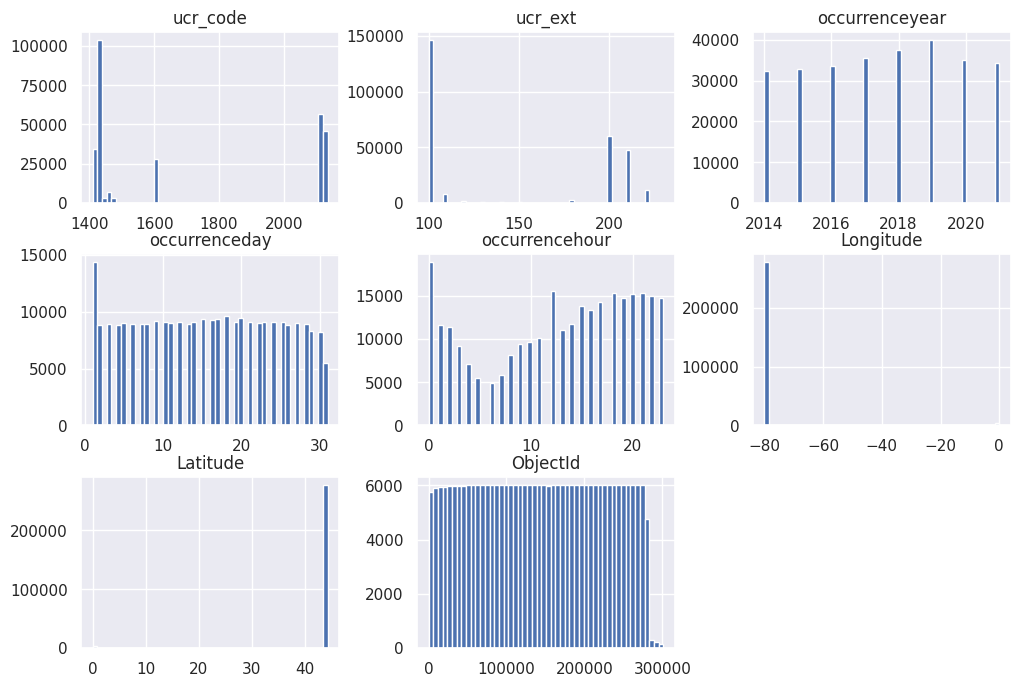

In [368]:
### Exploring the data to gain insigths / Histogram for each numerical atribute
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(12,8))
plt.show()

occurrenceyear
2014.0    16820
2015.0    18128
2016.0    19009
2017.0    19631
2018.0    19919
2019.0    20932
2020.0    18180
2021.0    18671
Name: Assault, dtype: int64


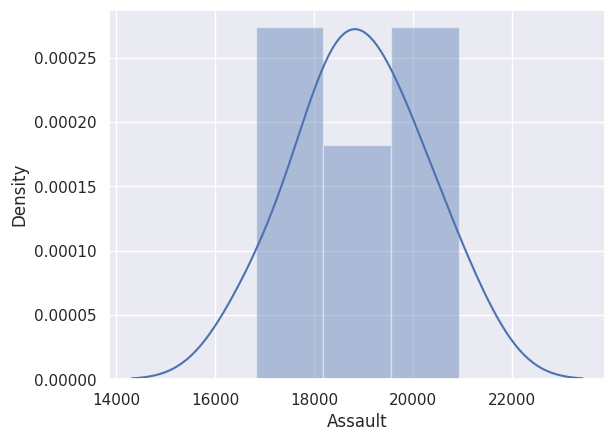

occurrenceyear
2014.0    3645
2015.0    3265
2016.0    3346
2017.0    3654
2018.0    4829
2019.0    5369
2020.0    5766
2021.0    6541
Name: Auto Theft, dtype: int64


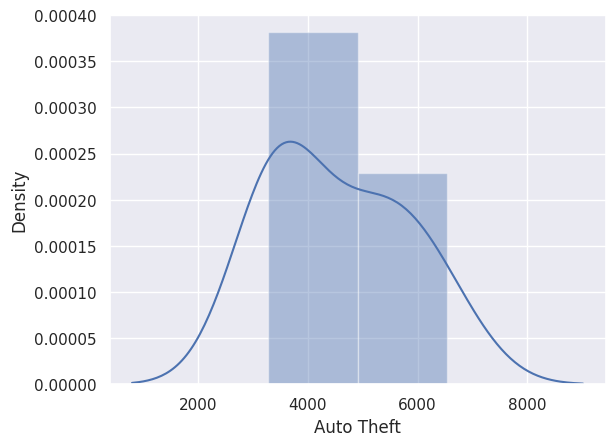

occurrenceyear
2014.0    7231
2015.0    6939
2016.0    6435
2017.0    6938
2018.0    7652
2019.0    8574
2020.0    6960
2021.0    5717
Name: Break and Enter, dtype: int64


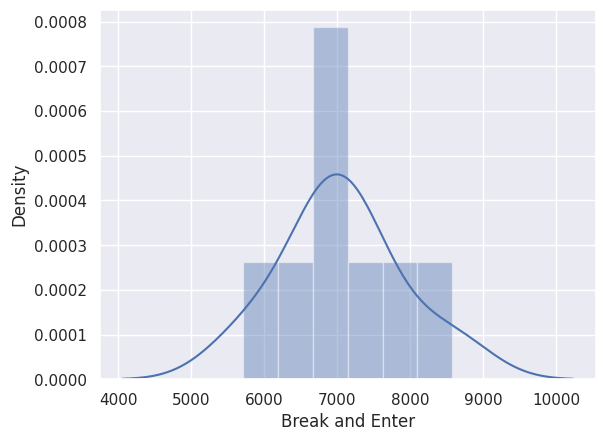

occurrenceyear
2014.0    3757
2015.0    3545
2016.0    3776
2017.0    4092
2018.0    3755
2019.0    3723
2020.0    2858
2021.0    2280
Name: Robbery, dtype: int64


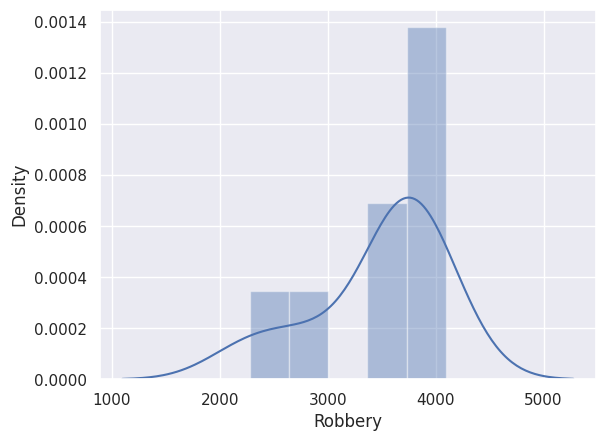

occurrenceyear
2014.0    1014
2015.0    1043
2016.0    1042
2017.0    1186
2018.0    1285
2019.0    1369
2020.0    1209
2021.0    1068
Name: Theft Over, dtype: int64


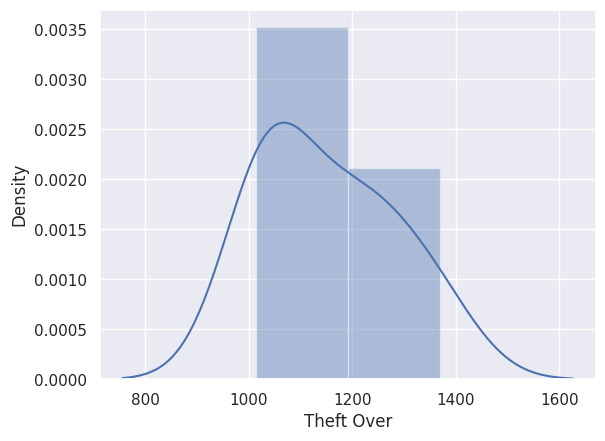

occurrenceyear
2014.0    32467
2015.0    32920
2016.0    33608
2017.0    35501
2018.0    37440
2019.0    39967
2020.0    34973
2021.0    34277
Name: All, dtype: int64


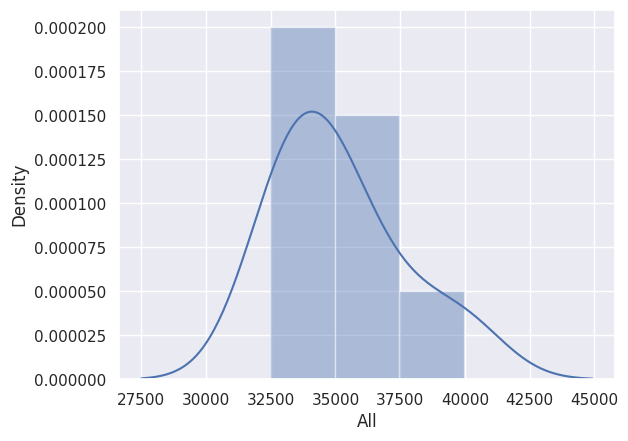

In [369]:
### Exploring the data to gain insigths
### Kurtosis from data_crosstable // Feb 27,2023
for i in range(0, data_ct.shape[0]):
    print (data_ct.iloc[i, 0:-1])
    sns.distplot(data_ct.iloc[i, 0:-1])
    #data_ct.iloc[i, 0:-1].hist(bins=5)
    plt.show()

Text(0, 0.5, 'Count of Occurreneces')

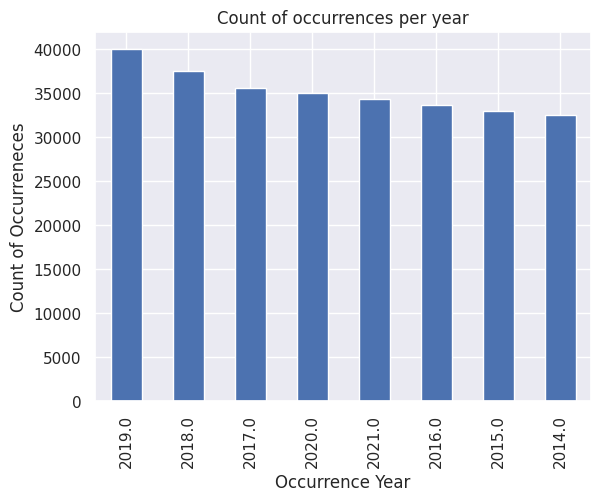

In [370]:
viz = data['occurrenceyear'].value_counts() \
.head(10) \
.plot(kind='bar', title='Count of occurrences per year')
viz.set_xlabel('Occurrence Year')
viz.set_ylabel('Count of Occurreneces')

## 3.1 MCI Category

In [371]:
### Exploring the data to gain insigths // MCI CATEGORY
### Trying to find data correlation / crosstab // Feb 24, 2023
data_ct_t =  pd.crosstab(data.mci_category, data.occurrenceyear, margins=False).reindex()
data_ct_t = data_ct_t.T
type_corr = data_ct_t.corr()
type_corr

mci_category,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
mci_category,,,,,
Assault,1.000000,0.244606,0.490954,0.254943,0.812005
Auto Theft,0.244606,1.000000,-0.072129,-0.785894,0.424078
Break and Enter,0.490954,-0.072129,1.000000,0.566080,0.743348
Robbery,0.254943,-0.785894,0.566080,1.000000,0.178567
Theft Over,0.812005,0.424078,0.743348,0.178567,1.000000


(5.5, -0.5)

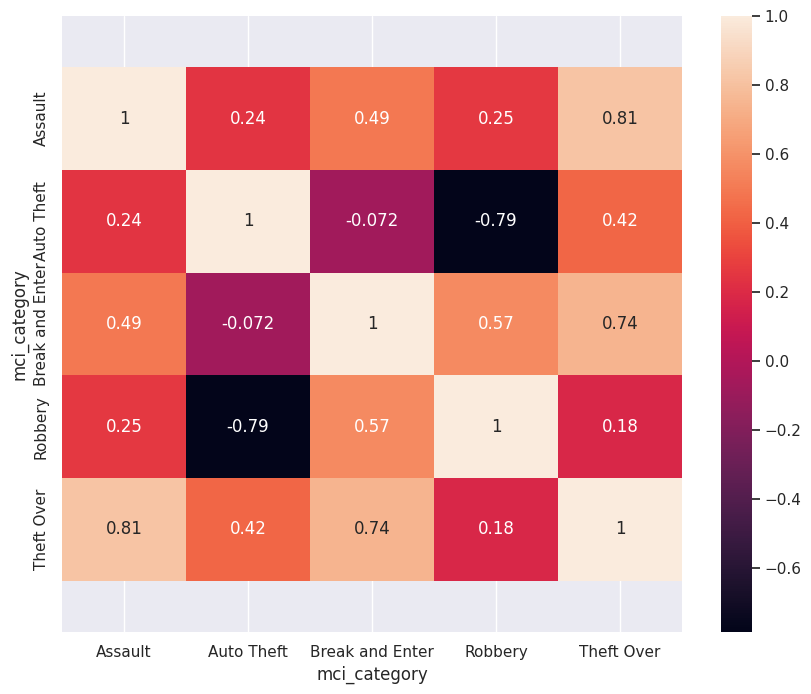

In [372]:
### Exploring the data to gain insigths
### Trying to find data correlation using sns seaborn // Feb 24, 2023
plt.figure(figsize=(10,8))
ax = sns.heatmap(type_corr, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

Correlations: Only >=0.5

1.   **Assault** has high correlation with **Theft Over** 
2. **Auto Theft** has high correlation with **NONE**
3. **Break and Enter** has correlation with **Roberry** and **Theft Over** 
4. **Robbery** has high correlation with **Break and Enter**
5. **Theft Over** has high correlation with **Assault** and **Break and Enter**

In [373]:
### Exploring the data to gain insigths / MCI per year analysis // March 7, 2023
mciYear = data_ct.loc['All']
df_ct = data_ct.iloc[:-1,:]
mciYear = mciYear[:-1]
mciYear

occurrenceyear
2014.0    32467
2015.0    32920
2016.0    33608
2017.0    35501
2018.0    37440
2019.0    39967
2020.0    34973
2021.0    34277
Name: All, dtype: int64

In [374]:
### Exploring the data to gain insigths / MCI per year analysis // March 7, 2023
data_annual = pd.concat([pd.Series(mciYear.index, name='Year'), 
                       pd.Series(mciYear.values, name='Type')], axis=1).reset_index()
data_annual = data_annual.drop(columns=['index'])
data_annual

,Year,Type
0,2014.0,32467
1,2015.0,32920
2,2016.0,33608
3,2017.0,35501
4,2018.0,37440
5,2019.0,39967
6,2020.0,34973
7,2021.0,34277


Text(0.5, 1.0, 'Annual Total MCI')

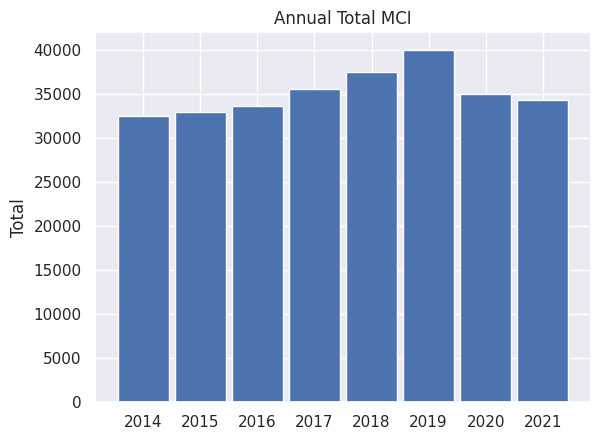

In [375]:
### Exploring the data to gain insigths / MCI per year analysis / Annual Total MCI Bar graph // March 7, 2023
plt.bar('Year', height='Type', width=0.9, align='center', data=data_annual)
plt.ylabel('Total')
plt.title('Annual Total MCI')

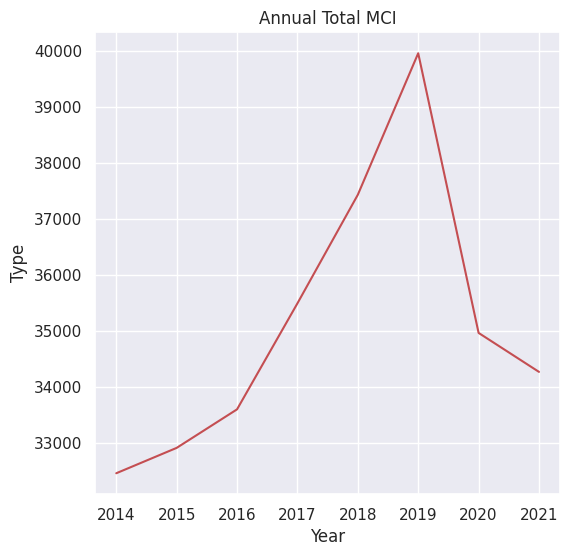

In [376]:
### Exploring the data to gain insigths / MCI per year analysis / Annual Total MCI Line graph // March 7, 2023
fig, ax = plt.subplots(figsize=(6,6))
sns.lineplot(x='Year', y='Type', data=data_annual, color='r')
ax.set_title('Annual Total MCI')
plt.show()

## 3.2 MCI by neighbourhood

In [377]:
### Exploring the data to gain insigths / MCI by neighbourhood // March 7, 2023
data_hood_ct = pd.crosstab(data.Neighbourhood, data.occurrenceyear, margins=True)
data_hood_ct.sort_values("All", axis = 0, ascending = False,
                 inplace = True) 
data_hood_ct.head(6)

occurrenceyear,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,All
Neighbourhood,,,,,,,,,
All,32467,32920,33608,35501,37440,39967,34973,34277,281153
Waterfront Communities-The Island,1035,1142,1241,1336,1466,1402,1323,1528,10473
Church-Yonge Corridor,876,896,943,1168,1319,1458,1240,1431,9331
Bay Street Corridor,784,960,949,1182,1160,1342,887,798,8062
West Humber-Clairville,887,818,876,936,1145,1014,879,941,7496
Moss Park,654,651,734,718,935,1086,1156,919,6853


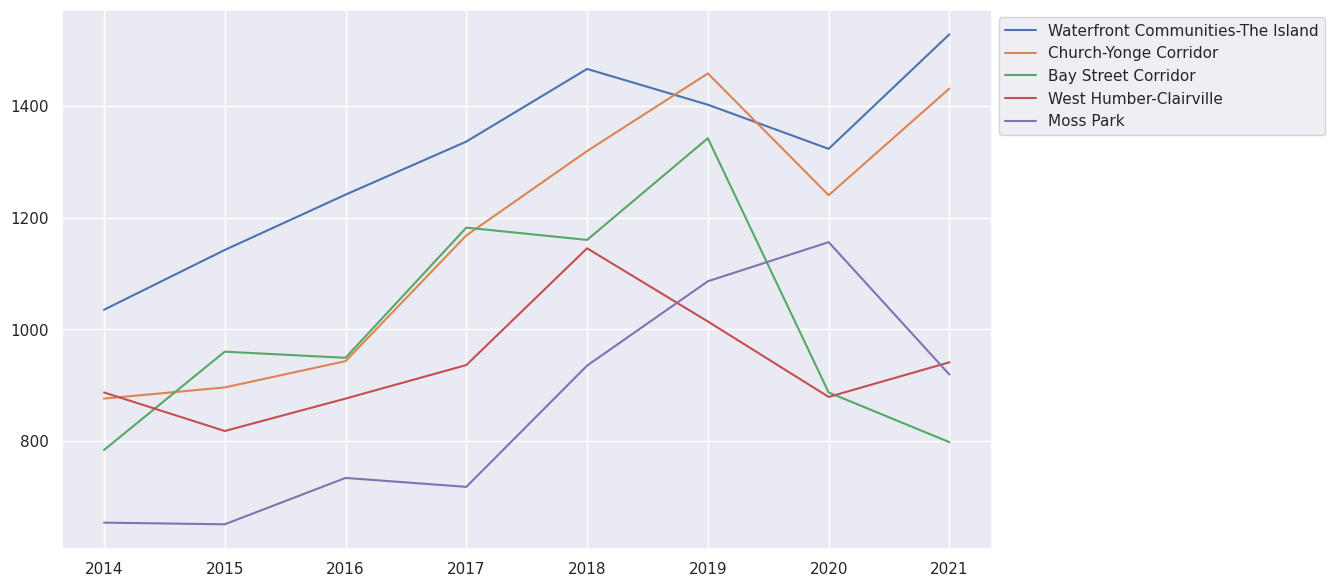

In [378]:
### Exploring the data to gain insigths / MCI by most dangerous neighbourhood // March 7, 2023
top5danger = data_hood_ct.iloc[1:6,:8].T
fig, ax = plt.subplots(1,1,figsize=(12,7))
ax.plot(top5danger)
ax.legend(top5danger.columns.to_list(), loc="best", bbox_to_anchor = (1,1))

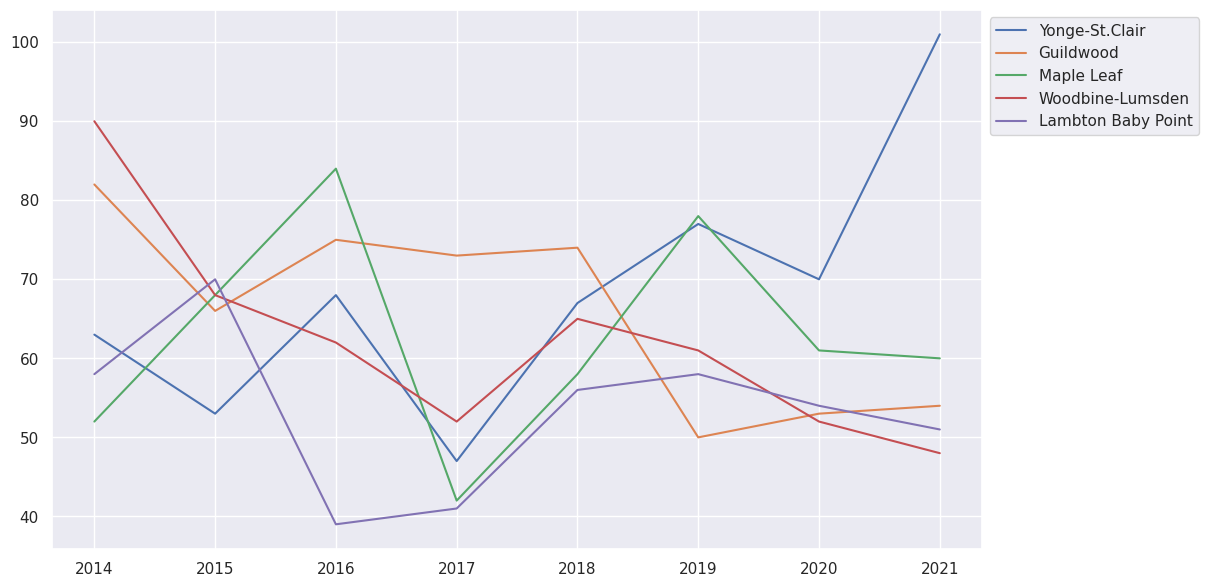

In [379]:
### Exploring the data to gain insigths 
### MCI by most dangerous neighbourhood // March 7, 2023
top5safe = data_hood_ct.iloc[-5:,:8].T
fig, ax = plt.subplots(1,1,figsize=(12,7))
ax.plot(top5safe)
ax.legend(top5safe.columns.to_list(), loc="best", bbox_to_anchor = (1,1))

In [380]:
### Exploring the data to gain insigths
### MCI by safest neighbourhood // March 7, 2023
data_hood_ct.tail(5)

occurrenceyear,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,All
Neighbourhood,,,,,,,,,
Yonge-St.Clair,63,53,68,47,67,77,70,101,546
Guildwood,82,66,75,73,74,50,53,54,527
Maple Leaf,52,68,84,42,58,78,61,60,503
Woodbine-Lumsden,90,68,62,52,65,61,52,48,498
Lambton Baby Point,58,70,39,41,56,58,54,51,427


## 3.3 Most dangerous hours


In [381]:
### Exploring the data to gain insigths 
### MCI by hour of the day // March 21, 2023
data_hourly_ct = pd.crosstab(data.mci_category, data.occurrencehour, margins=False)
#data_hourly_ct = pd.crosstab(data.occurrencehour, data.mci_category,margins=False)
data_hourly_ct.head()

occurrencehour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
mci_category,,,,,,,,,,,,,,,,,,,,,
Assault,9830,6290,6491,4352,2773,2057,2112,2784,4257,5077,...,6898,8327,7702,7992,8320,7980,8062,7988,7545,7586
Auto Theft,2337,1217,964,800,696,617,680,913,931,984,...,1096,1163,1507,1841,2335,2345,2726,2905,3228,2898
Break and Enter,4217,2492,2571,2881,2831,2313,1617,1692,2337,2411,...,2116,2035,2047,2357,2535,2228,2033,2000,1977,2182
Robbery,1487,1429,1179,946,619,410,367,264,321,421,...,1158,1739,1570,1525,1573,1739,1914,2031,1912,1767
Theft Over,956,193,179,150,122,101,104,159,244,465,...,490,501,499,577,546,448,421,382,317,307


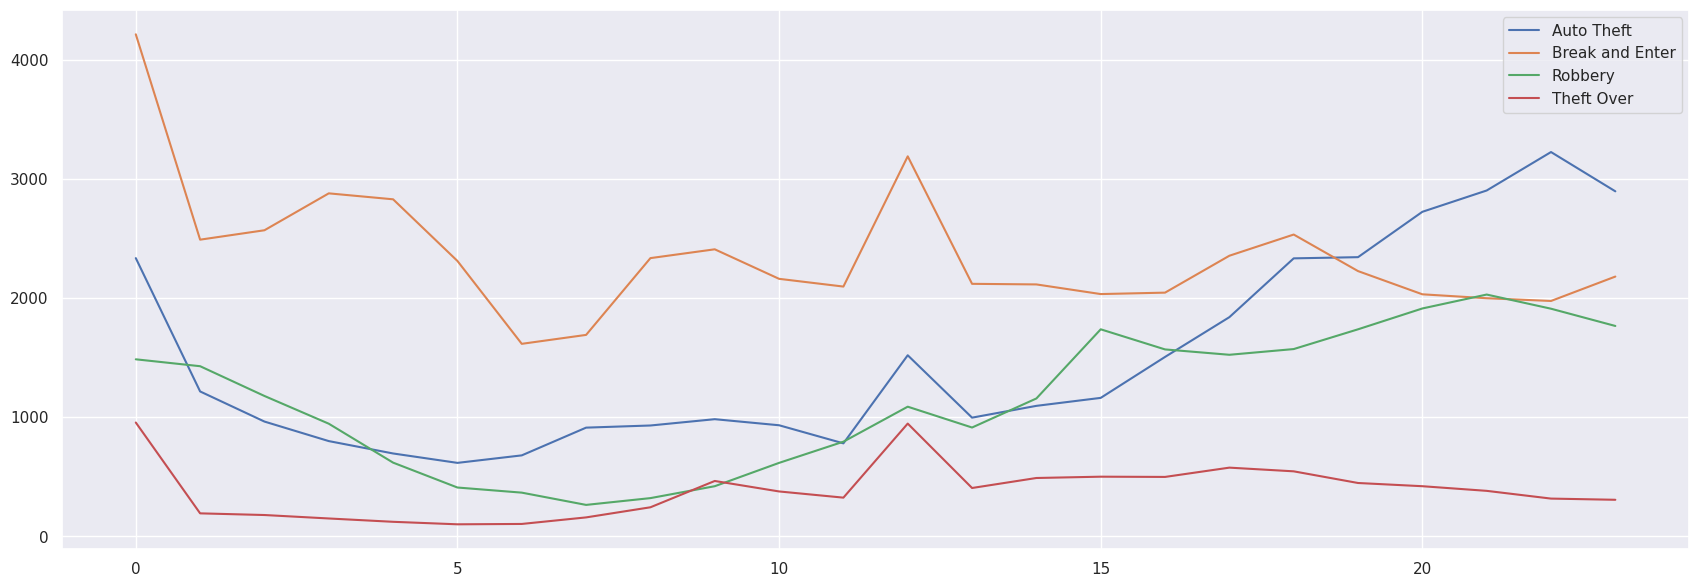

In [382]:
### Exploring the data to gain insigths 
### MCI by hour of the day // March 21, 2023
hourly_analysis = data_hourly_ct.iloc[1:23].T
fig, ax = plt.subplots(1,1,figsize=(21,7))
ax.plot(hourly_analysis)
ax.legend(hourly_analysis.columns.to_list(), loc="best", bbox_to_anchor = (1,1))

## 3.4 Most Dangerous days of the week

In [383]:
### Exploring the data to gain insigths / MCI by day of the week // March 21, 2023
data_wdays_ct = pd.crosstab(data.mci_category, data.occurrencedayofweek, margins=False)
data_wdays_ct.head()

occurrencedayofweek,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
mci_category,,,,,,,
Assault,22012,20494,23888,23738,20464,19874,20820
Auto Theft,5507,5121,4821,4782,5454,5242,5488
Break and Enter,9308,8189,7572,6990,8283,8006,8098
Robbery,4353,3842,4279,3653,3905,3846,3908
Theft Over,1558,1362,1171,1045,1373,1359,1348


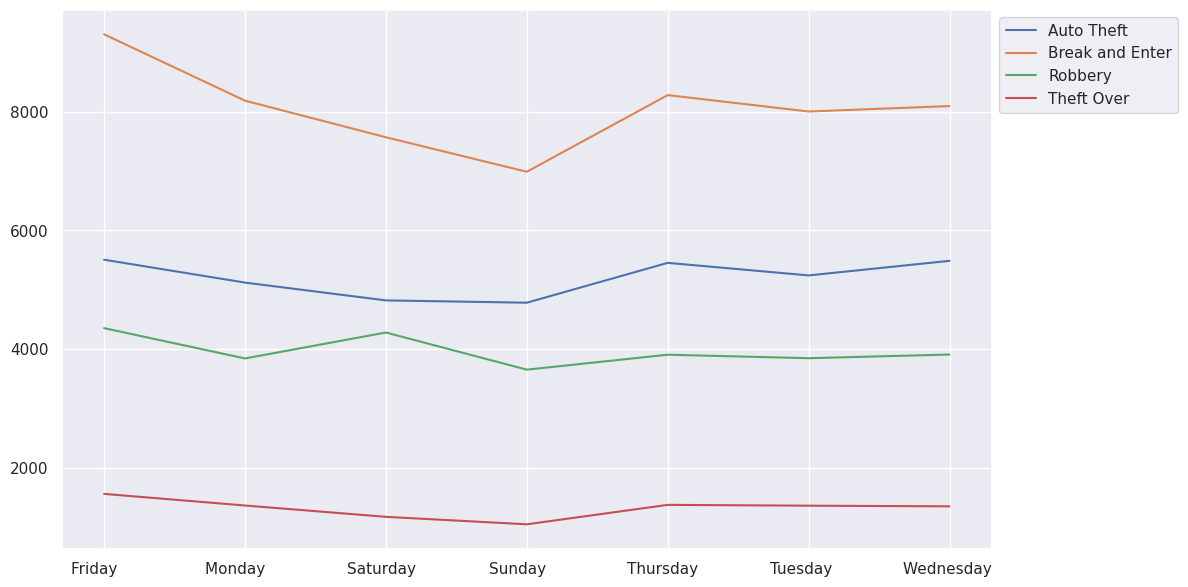

In [384]:
### Exploring the data to gain insigths / MCI by day of the week // March 21, 2023
wdays_analysis = data_wdays_ct.iloc[1:23].T
fig, ax = plt.subplots(1,1,figsize=(12,7))
ax.plot(wdays_analysis)
ax.legend(wdays_analysis.columns.to_list(), loc="best", bbox_to_anchor = (1,1))

In [385]:
### Exploring the data to gain insigths
### Trying to find data correlation using sns seaborn // March 21, 2023
data_ct_t =  pd.crosstab(data.mci_category, data.occurrencedayofweek, margins=False).reindex()
data_ct_t = data_ct_t.T
type_corr = data_ct_t.corr()
type_corr

mci_category,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
mci_category,,,,,
Assault,1.000000,-0.705800,-0.463211,0.268135,-0.637415
Auto Theft,-0.705800,1.000000,0.818452,0.222093,0.873520
Break and Enter,-0.463211,0.818452,1.000000,0.596102,0.976207
Robbery,0.268135,0.222093,0.596102,1.000000,0.470616
Theft Over,-0.637415,0.873520,0.976207,0.470616,1.000000


(5.5, -0.5)

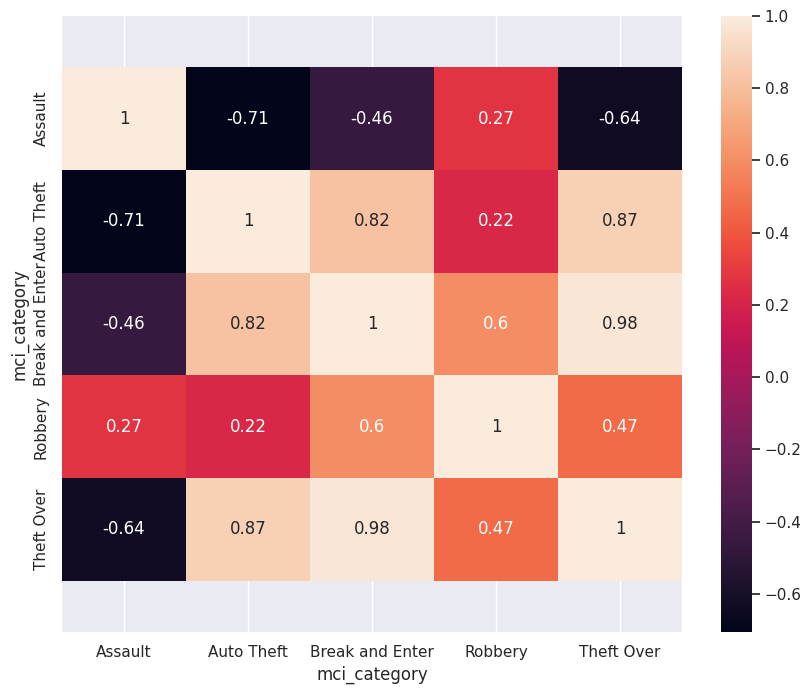

In [386]:
plt.figure(figsize=(10,8))
ax = sns.heatmap(type_corr, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [387]:
### Exploring the data to gain insigths
### Trying to find data correlation using sns seaborn // March 21, 2023
data_ct_t =  pd.crosstab(data.occurrencedayofweek, data.mci_category, margins=False).reindex()
data_ct_t = data_ct_t.T
type_corr = data_ct_t.corr()
type_corr

occurrencedayofweek,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
occurrencedayofweek,,,,,,,
Friday,1.000000,0.999663,0.994277,0.992604,0.999412,0.999460,0.998878
Monday,0.999663,1.000000,0.996144,0.995112,0.999844,0.999911,0.999720
Saturday,0.994277,0.996144,1.000000,0.999544,0.995268,0.995768,0.996465
Sunday,0.992604,0.995112,0.999544,1.000000,0.994420,0.994860,0.995914
Thursday,0.999412,0.999844,0.995268,0.994420,1.000000,0.999982,0.999857
Tuesday,0.999460,0.999911,0.995768,0.994860,0.999982,1.000000,0.999886
Wednesday,0.998878,0.999720,0.996465,0.995914,0.999857,0.999886,1.000000


(7.5, -0.5)

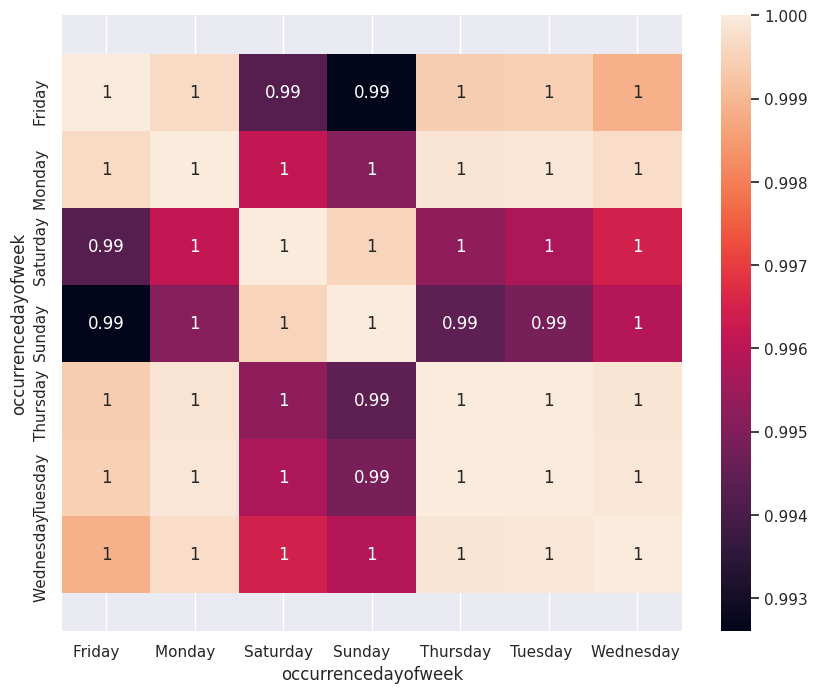

In [388]:
plt.figure(figsize=(10,8))
ax = sns.heatmap(type_corr, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

## 3.5 Latitute and Longitude 

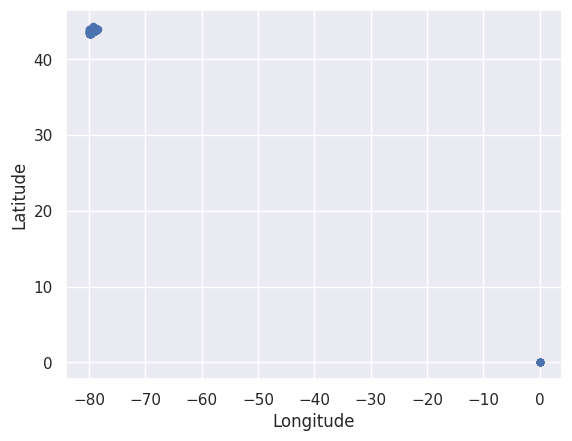

In [389]:
### Exploring the data to gain insigths / Visualizing Goegraphical Data
import matplotlib.pyplot as plt
data.plot(kind="scatter", x="Longitude", y="Latitude", grid=True)
plt.show()

In [390]:
### Clean the data (68)
### Get rid of the instance / Get rid of the whole attribute / Set the missing values to some value (zero, median, mean, etc.)
### Panda's dataframe > dropna(), drop(), fillna() + Scikit-Learn SimpleImputer
### Solving the issue with Latitude and Longitude - ZERO VALUES

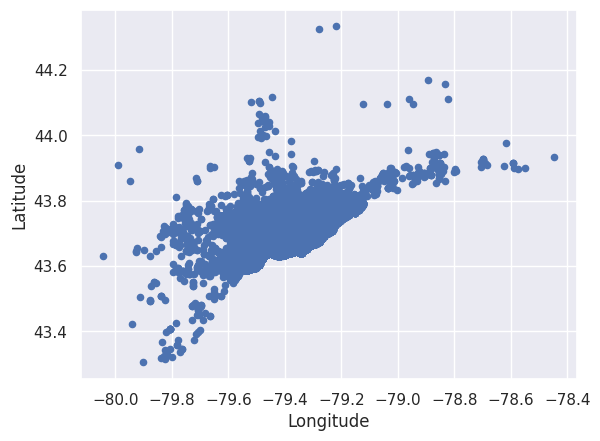

In [391]:
### Replace ZERO values for NaN = "Not a Number"
### data.replace(0, np.nan, inplace=True) ### To replace all the columns
cols = ["Latitude","Longitude"]
data[cols] = data[cols].replace(['0', 0], np.nan)
import matplotlib.pyplot as plt
data.plot(kind="scatter", x="Longitude", y="Latitude", grid=True)
plt.show()

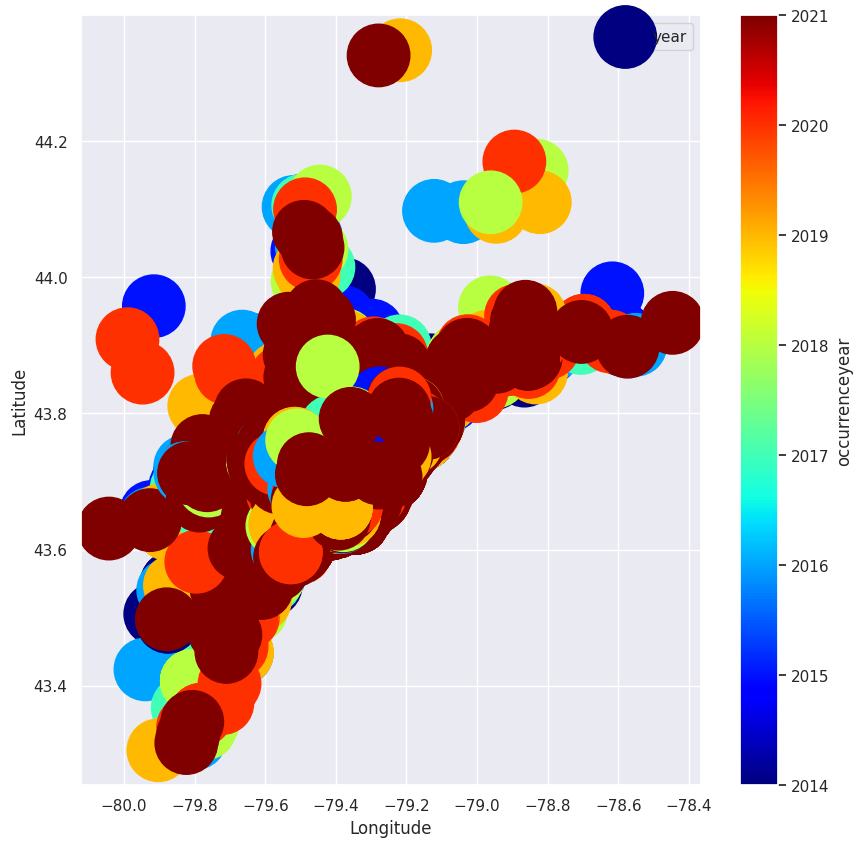

In [392]:
### Exploring the data to gain insigths / Ploting Latitude + Longitude to visualize the data
import matplotlib.pyplot as plt
data.plot(kind="scatter", x="Longitude", y="Latitude", grid=True, 
          s=data["occurrenceyear"], label = "year",
          c="occurrenceyear", cmap="jet", colorbar=True, 
          legend=True, sharex=False, figsize=(10,10))
plt.show()

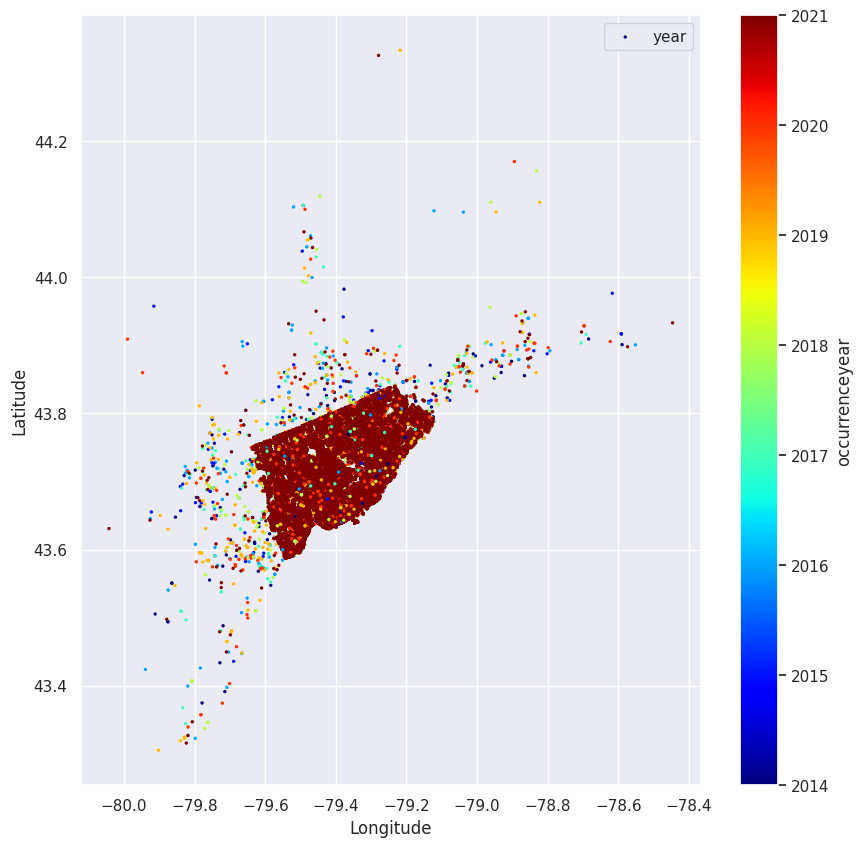

In [393]:
### Exploring the data to gain insigths
### Ploting Latitude + Longitude to visualize the data
import matplotlib.pyplot as plt
data.plot(kind="scatter", x="Longitude", y="Latitude", grid=True, 
          s=2, label = "year",
          c="occurrenceyear", cmap="jet", colorbar=True, 
          legend=True, sharex=False, figsize=(10,10))
plt.show()

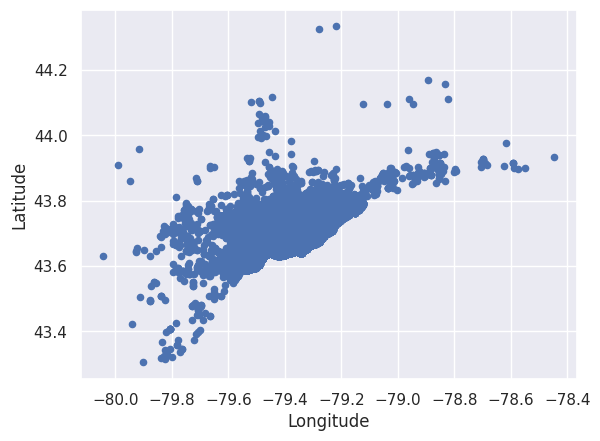

In [394]:
### Exploring the data to gain insigths
### Experiments - Attribute combinations
import matplotlib.pyplot as plt
data.plot(kind="scatter", x="Longitude", y="Latitude", grid=True)
plt.show()

In [395]:
### Exploring the data to gain insigths / Looking for correlations
#corr_matrix = data.corr()
#corr_matrix ["ucr_code"].sort_values(ascending=False)

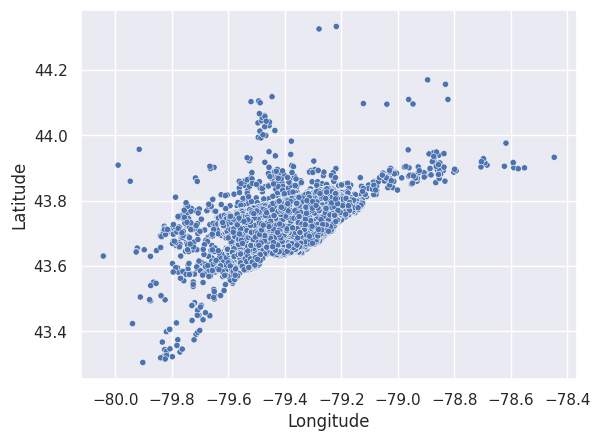

In [396]:
### Exploring the data to gain insigths
### Ploting Latitude + Longitude to visualize the data
graph = data.loc[data.Neighbourhood == 2015]
sns.scatterplot(data=data, x="Longitude", y="Latitude", size=1, legend=False, sizes=(20, 2000))
plt.show()

## 3.6 Toronto Map + Merging data
Merging data with aditional dataset
Download shape file to use for the Toronto Map // March 8, 2023
https://open.toronto.ca/dataset/neighbourhoods/
field	name / description 
FIELD_1	_id                    FIELD_2	AREA_ID           FIELD_3	AREA_ATTR_ID
FIELD_4	PARENT_AREA_ID         FIELD_5	AREA_SHORT_CODE   FIELD_6	AREA_LONG_CODE
FIELD_7	AREA_NAME              FIELD_8	AREA_DESC         FIELD_9	CLASSIFICATION
FIELD_10 CLASSIFICATION_CODE   FIELD_11 OBJECTID          geometry	geometry

In [397]:
### Tutorial -> Create a geographic heat map of the City of Toronto in Python // March 8, 2023
### https://medium.com/@m_vemuri/create-a-geographic-heat-map-of-the-city-of-toronto-in-python-cd2ae0f8be55
!pip install geopandas
import geopandas as gpd
sns.set(style="darkgrid")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [398]:
### Exploring the data to gain insigths / Group by 'Hood_ID','Neighbourhood' and count // March 8, 2023
data_gp = data.groupby(['Hood_ID','Neighbourhood']).count()[['premises_type']]
data_gp= data_gp.reset_index()
data_gp

,Hood_ID,Neighbourhood,premises_type
0,1,West Humber-Clairville,7496
1,10,Princess-Rosethorn,686
2,100,Yonge-Eglinton,1048
3,101,Forest Hill South,708
4,102,Forest Hill North,856
...,...,...,...
136,96,Casa Loma,732
137,97,Yonge-St.Clair,546
138,98,Rosedale-Moore Park,2032
139,99,Mount Pleasant East,766


In [399]:
### Exploring the data to gain insigths / Group by 'Hood_ID','Neighbourhood' and count // March 8, 2023
data['count'] = 1
dataByNeighbourhood = data.groupby('Neighbourhood').count()[['count']].reset_index()
dataByNeighbourhood['Neighbourhood'] = dataByNeighbourhood['Neighbourhood'].str.lower()
dataByNeighbourhood.sort_values('count', ascending=False).head(5)

,Neighbourhood,count
123,waterfront communities-the island,10473
23,church-yonge corridor,9331
6,bay street corridor,8062
125,west humber-clairville,7496
79,moss park,6853


In [400]:
dataByNeighbourhood.head(5)

,Neighbourhood,count
0,agincourt north,1480
1,agincourt south-malvern west,2180
2,alderwood,758
3,annex,4358
4,banbury-don mills,1552


In [401]:
### Download shape file to use for the Toronto Map // March 8, 2023
### https://open.toronto.ca/dataset/neighbourhoods/
### field	name / description 
### FIELD_1	_id                    FIELD_2	AREA_ID           FIELD_3	AREA_ATTR_ID
### FIELD_4	PARENT_AREA_ID         FIELD_5	AREA_SHORT_CODE   FIELD_6	AREA_LONG_CODE
### FIELD_7	AREA_NAME              FIELD_8	AREA_DESC         FIELD_9	CLASSIFICATION
### FIELD_10 CLASSIFICATION_CODE   FIELD_11 OBJECTID          geometry	geometry
#regions = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/Neighbourhoods.shp')
#regions.sample(1)

In [402]:
### Plot the data based on the downloaded shape file - Toronto Map // March 8, 2023
### https://open.toronto.ca/dataset/neighbourhoods/
#regions.plot(figsize=(20,10))
#plt.show()

In [403]:
#regions['FIELD_7'] = regions['FIELD_7'].str.lower()
#merged = regions.set_index('FIELD_7').join(dataByNeighbourhood.set_index('Neighbourhood'))
#merged = merged.reset_index()
#merged = merged.fillna(0)
#merged[['FIELD_7', 'geometry', 'count']].sample(1)

In [404]:
#merged.shape

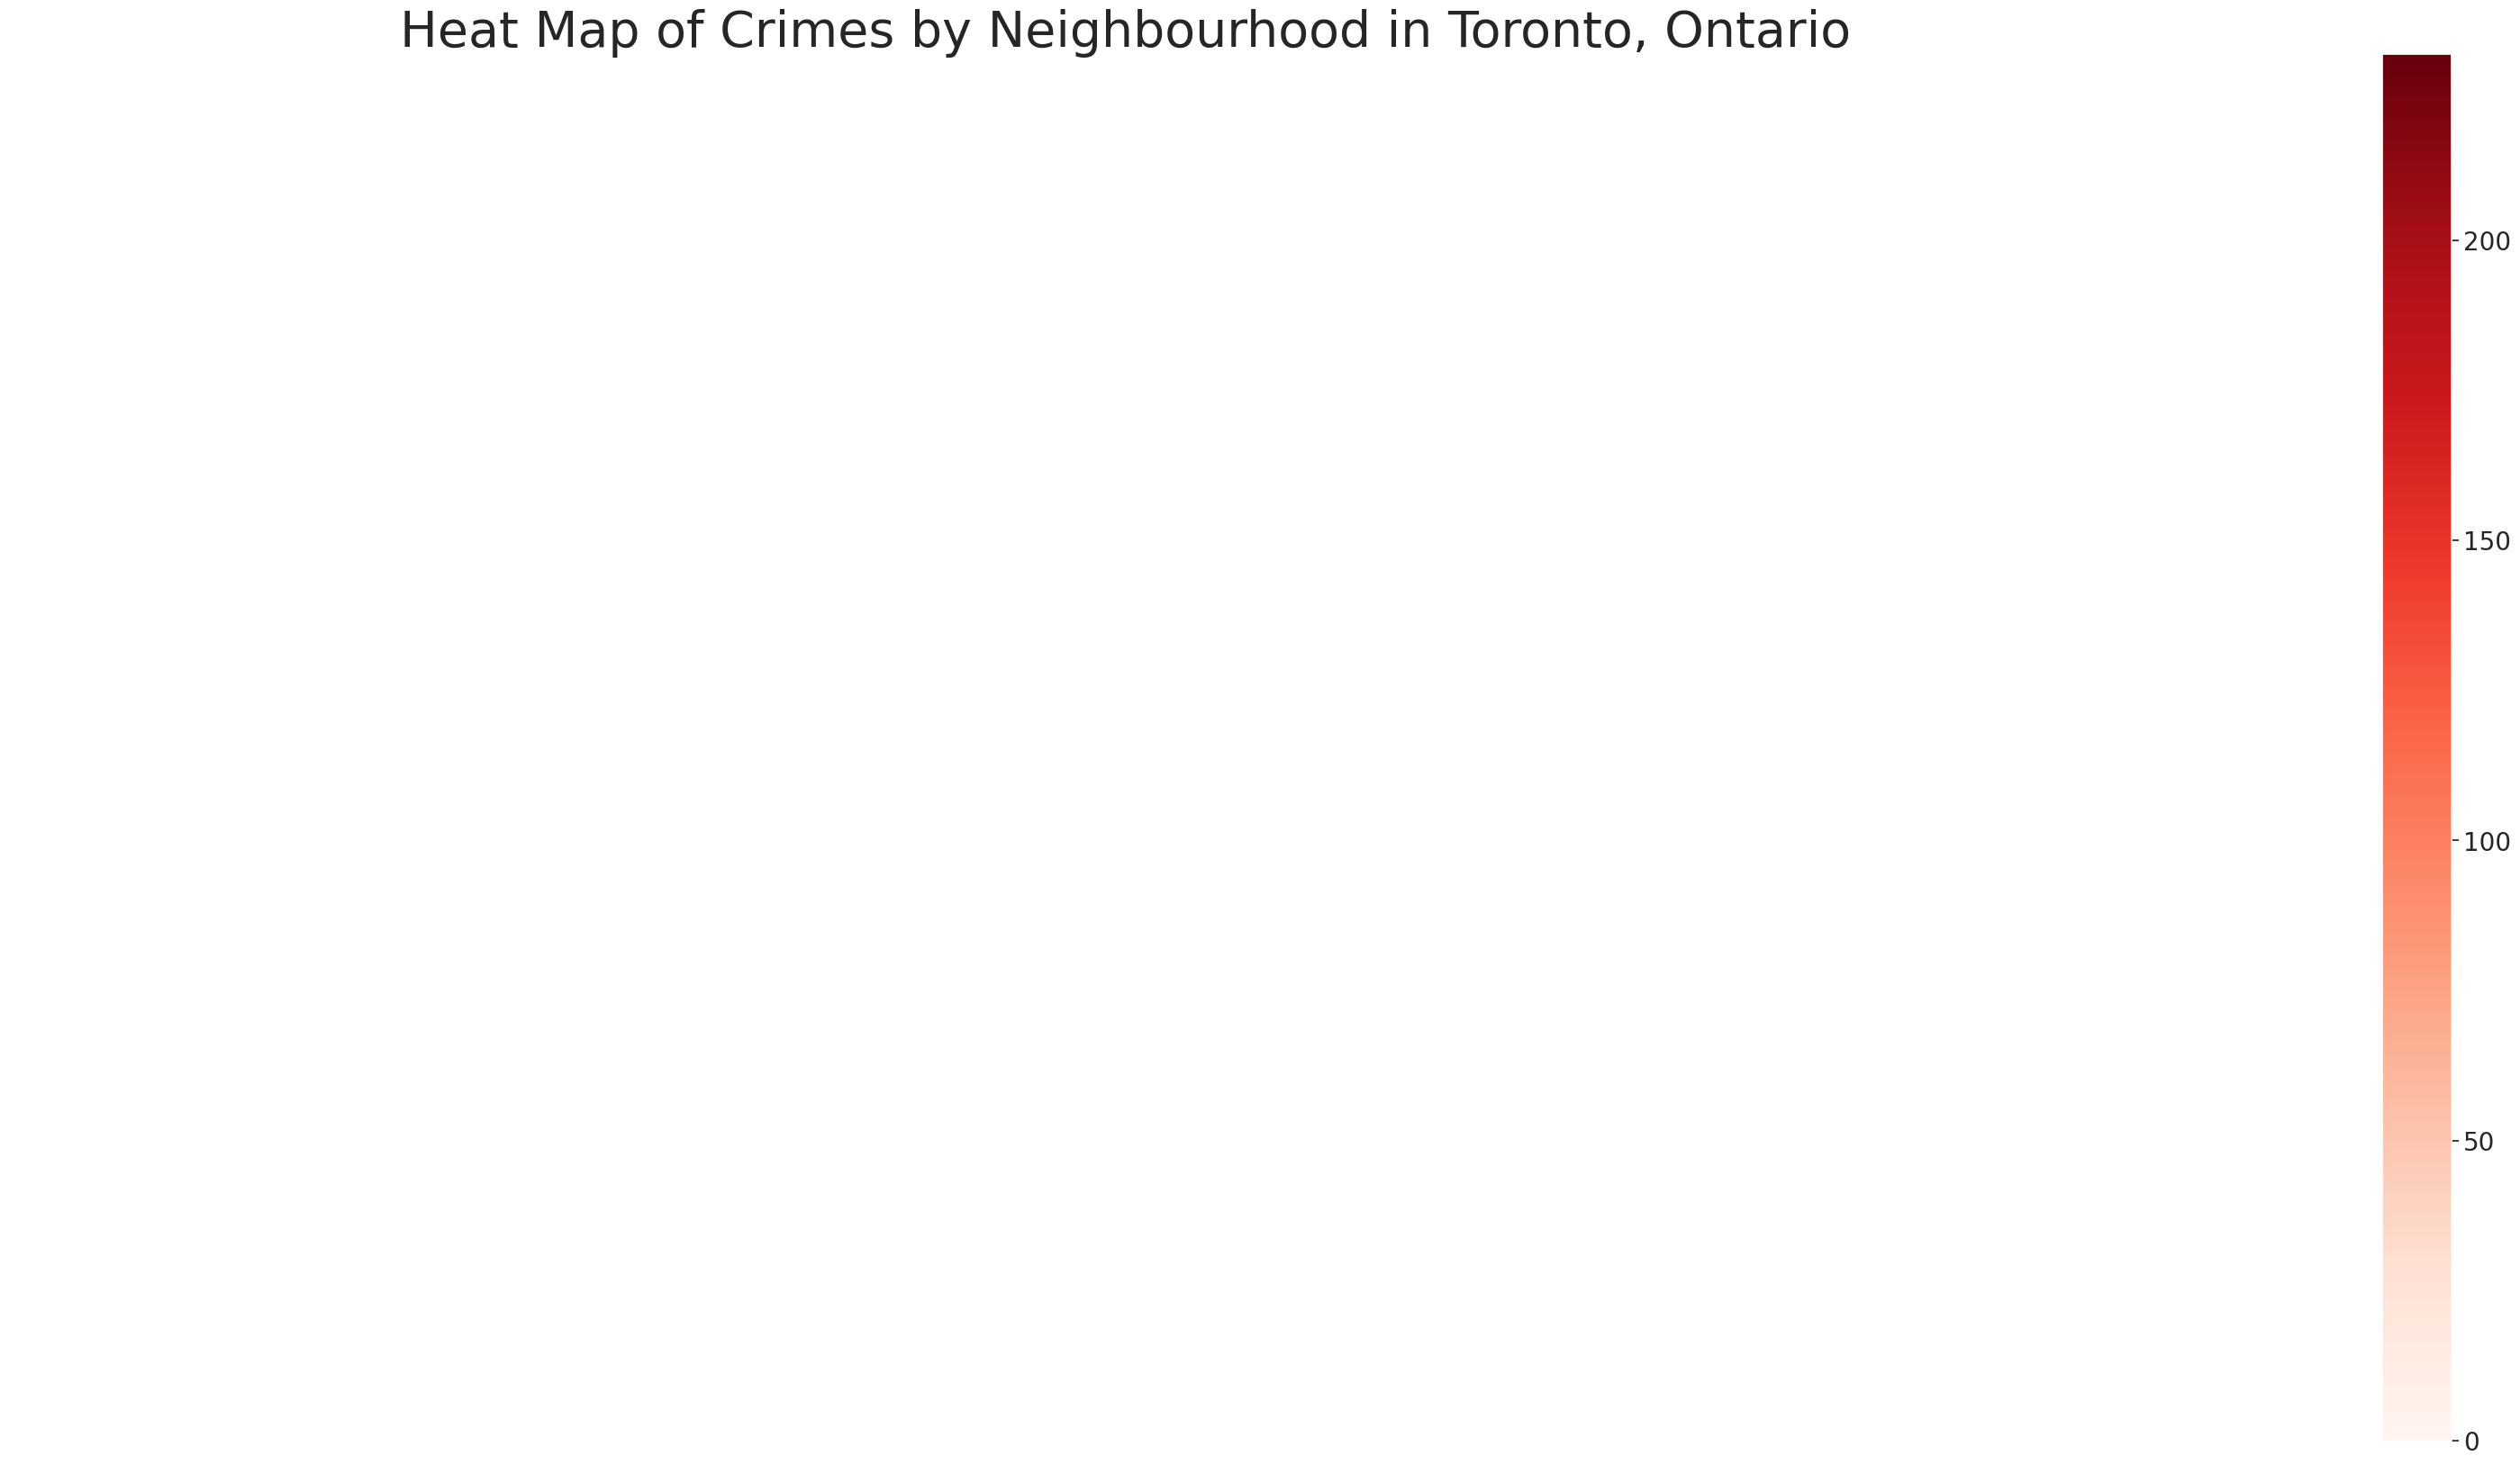

In [405]:
fig, ax = plt.subplots(1, figsize=(40, 20))
ax.axis('off')
ax.set_title('Heat Map of Crimes by Neighbourhood in Toronto, Ontario', fontdict={'fontsize': '40', 'fontweight' : '3'})
color = 'Reds'
vmin, vmax = 0, 231
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)
#merged.plot('count', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20))

In [406]:
data.describe()

,ucr_code,ucr_ext,occurrenceyear,occurrenceday,occurrencehour,Longitude,Latitude,ObjectId,count
count,281153.000000,281153.000000,281153.000000,281153.000000,281153.000000,277572.000000,277572.000000,281153.000000,281153.0
mean,1700.832821,146.402578,2017.578162,15.492689,12.618443,-79.396262,43.706926,141582.294171,1.0
std,325.535649,51.917990,2.250533,8.904309,7.232738,0.104750,0.053341,81453.182017,0.0
min,1410.000000,100.000000,2014.000000,1.000000,0.000000,-80.042866,43.304981,1.000000,1.0
25%,1430.000000,100.000000,2016.000000,8.000000,7.000000,-79.471876,43.660816,71137.000000,1.0
50%,1450.000000,100.000000,2018.000000,16.000000,14.000000,-79.394093,43.700476,141567.000000,1.0
75%,2120.000000,200.000000,2019.000000,23.000000,19.000000,-79.324574,43.751664,212067.000000,1.0
max,2135.000000,230.000000,2021.000000,31.000000,23.000000,-78.446267,44.333691,301206.000000,1.0


In [407]:
data.head()

,Division,occurrencedate,location_type,premises_type,ucr_code,ucr_ext,offence,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofweek,occurrencehour,mci_category,Hood_ID,Neighbourhood,Longitude,Latitude,ObjectId,count
0,D31,2014/01/03 05:00:00+00,"Apartment (Rooming House, Condo)",Apartment,1430,100,Assault,2014.0,January,3.0,Friday,11,Assault,27,York University Heights,-79.504475,43.766371,1,1
1,D42,2014/01/03 05:00:00+00,"Single Home, House (Attach Garage, Cottage, Mo...",House,2120,200,B&E,2014.0,January,3.0,Friday,14,Break and Enter,132,Malvern,-79.217083,43.814861,2,1
2,D22,2014/01/03 05:00:00+00,"Open Areas (Lakes, Parks, Rivers)",Outside,1430,100,Assault,2014.0,January,3.0,Friday,13,Assault,19,Long Branch,-79.534957,43.589085,3,1
3,D53,2014/01/03 05:00:00+00,Other Commercial / Corporate Places (For Profi...,Commercial,2130,210,Theft Over,2014.0,January,3.0,Friday,12,Theft Over,55,Thorncliffe Park,-79.346588,43.703212,4,1
4,D22,2014/01/03 05:00:00+00,Convenience Stores,Commercial,1610,210,Robbery - Business,2014.0,January,3.0,Friday,14,Robbery,14,Islington-City Centre West,-79.531916,43.645247,5,1


In [408]:
### Plot the data based on the downloaded shape file - Toronto Map // March 16, 2023
### https://www.jiristodulka.com/post/toronto-crime/
###
import folium #maping crime on the map
from folium.plugins import HeatMap, MarkerCluster #making maping visually appealing
### Top N Criminal Neighbourhoods in Toronto 
top_N = data.groupby('Neighbourhood')[['mci_category']].count().sort_values(by=['mci_category'])
### Coordinates Criminal Neighbourhoods
map_data = data[['Neighbourhood', 'Latitude', 'Longitude']].drop_duplicates('Neighbourhood').set_index('Neighbourhood') \
    .join(top_N, how='inner')
map_data.sort_values(by=['mci_category'], ascending=False).head(10)

,Latitude,Longitude,mci_category
Neighbourhood,,,
Waterfront Communities-The Island,43.649131,-79.390756,10473
Church-Yonge Corridor,43.648627,-79.373824,9331
Bay Street Corridor,43.650868,-79.382626,8062
West Humber-Clairville,43.697108,-79.586443,7496
Moss Park,43.653729,-79.373215,6853
York University Heights,43.766371,-79.504475,5468
Kensington-Chinatown,43.653346,-79.396125,5396
Downsview-Roding-CFB,43.719831,-79.513761,5344
Woburn,43.773498,-79.230640,4989


In [409]:
x=data
map_data = map_data.dropna()

In [410]:
### Plot the data based on the downloaded shape file - Toronto Map // March 16, 2023
### https://www.jiristodulka.com/post/toronto-crime/
###

m = folium.Map(
    location=[43.702270, -79.366074],
    zoom_start=11
)
### Step 1: Clusters
cluster = MarkerCluster().add_to(m)
### Step 2: Clusters breaking into Markers
for x in map_data.iterrows():
    folium.Marker([x[1].Latitude, x[1].Longitude]).add_to(cluster)
### Step 3: Heat
max_crime = map_data['mci_category'].max() # max value as reference for the darkets shade
heat = HeatMap(map_data.values,
                min_opacity=0.2,
                max_val=max_crime,
                radius=30, blur=20, 
                max_zoom=11)
heat.add_to(m)
m

## 3.7 Correlations

In [411]:
### Exploring the data to gain insigths / Looking for correlations - using pandas Scatter Matrix
### Scatter Matrix plots every numerical atribute against every other attribite, plus a histogram of each numerical atribute's value on the main diagonal top left to bottom rigth 

#from pandas.plotting import scatter_matrix
#attributes = ["ucr_code", "ucr_ext", "occurrenceyear", "occurrenceday", "occurrencehour"]
#scatter_matrix(data[attributes], figsize=(12,8))
#plt.show()

# 4 - Prepare the data for ML algorithm


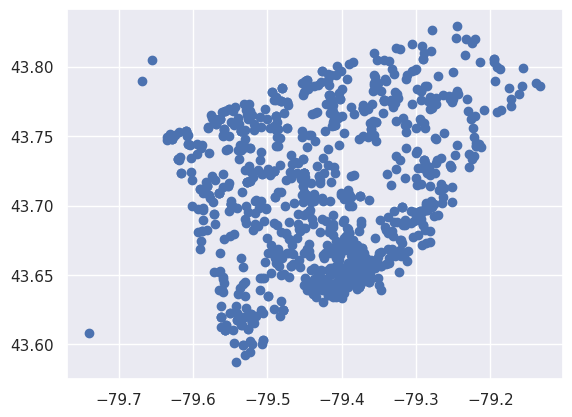

In [412]:
### UNSUPERVISED ML // DBSCAN
### mci_categories = 
data = data[(data.mci_category=='Theft Over')]     ### Limiting number of records to be processed
data_auto = data[['mci_category', 'occurrenceyear', 'premises_type' ,'Latitude','Longitude']]
data_auto = data_auto.dropna()
df = data_auto[data_auto.occurrenceyear >= 2021]  ### For the assignment goal we are reducing the dataset 

lat_long = df[['Latitude','Longitude']]
lat, longg = df.Latitude, df.Longitude
plt.scatter(longg, lat)

In [413]:
### DBSCAN to identify the clusters 
### Adding more parameters to optimize DBSCAN

from sklearn.cluster import DBSCAN
X = lat_long.to_numpy()                   

dbscan_cluster_model = DBSCAN(eps=0.02, min_samples=15, algorithm='ball_tree', metric='minkowski', leaf_size=90, p=2)
arr = dbscan_cluster_model.fit_predict(X)
print(dbscan_cluster_model.labels_)

uni, counts = np.unique(arr, return_counts=True)
d = dict(zip(uni, counts))
print(d)

[0 0 0 ... 0 0 0]
{-1: 73, 0: 834, 1: 28, 2: 52, 3: 61}


In [414]:
dbscan_cluster_model.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [415]:
### DBSCAN // the .lablels_ is a column that contains the numbner of the assigned cluster - the DBSCAN result
### Adding more parameters to optimize DBSCAN
df['cluster'] = dbscan_cluster_model.labels_
df.head()

,mci_category,occurrenceyear,premises_type,Latitude,Longitude,cluster
246327,Theft Over,2021.0,Apartment,43.694378,-79.300568,0
246328,Theft Over,2021.0,Outside,43.718444,-79.601698,0
246692,Theft Over,2021.0,Apartment,43.757606,-79.408507,0
246747,Theft Over,2021.0,Outside,43.688050,-79.471545,0
246944,Theft Over,2021.0,Apartment,43.603268,-79.506271,3


In [416]:
### DBSCAN // the .lablels_ is a column that contains the numner of the assigned cluster - the DBSCAN result
### Adding more parameters to optimize DBSCAN
df['cluster'].value_counts().sort_values()

 1     28
 2     52
 3     61
-1     73
 0    834
Name: cluster, dtype: int64

In [417]:
### Plot a graph using clusters data
import plotly.express as px
fig = px.scatter(x=longg, y=lat, color=df['cluster'], width=600, height=400)
fig.show()

# 5 - Fine-tunig the model

In [418]:
X.shape, df.shape

((1048, 2), (1048, 6))

In [419]:
### Calculating the Silhouette Score // From 1 to -1
from sklearn.metrics import silhouette_score as ss
ss(X, df['cluster'])

0.03517664393802231

In [420]:
### Grid search 
### Trying all the combinations betweeen epsilons and min_sampels one by one
epsilons = np.linspace(0.01, 1, num=15)
min_samples = np.arange(2, 20, step=3)   ### array([ 2,  5,  8, 11, 14, 17])
epsilons

array([0.01      , 0.08071429, 0.15142857, 0.22214286, 0.29285714,
       0.36357143, 0.43428571, 0.505     , 0.57571429, 0.64642857,
       0.71714286, 0.78785714, 0.85857143, 0.92928571, 1.        ])

In [421]:
import itertools  
combinations = list(itertools.product(epsilons, min_samples))   ### A long list combining epsilons and min_samples
N = len(combinations)                                           ### Number of combinations (count)

In [422]:
def get_scores_and_labels(combinations, X):
  scores = []            #empty list 
  all_labels_list = []   #empty list

  ### Many combinations of DBSCANS
  for i, (eps,num_samples) in enumerate(combinations):
    dbscan_cluster_model = DBSCAN (eps=eps, min_samples=num_samples).fit(X)
    labels = dbscan_cluster_model.labels_
    labels_set = set(labels)
    num_clusters = len(labels_set)
    if -1 in labels_set:
      num_clusters -= 1

    if (num_clusters < 2) or (num_clusters > 50):
      scores.append(-10)
      all_labels_list.append('bad')
      c=(eps,num_samples)
      print(f"Combination {c} on iteraction {i+1} of {N} has {num_clusters} clusters. Next...")
      continue

    scores.append(ss(X, labels))
    all_labels_list.append(labels)
    print(f"Index: {i}, Score: {scores[-1]}, Labels: {all_labels_list[-1]}, # Clusters: {num_clusters}")

  best_index = np.argmax(scores)
  best_parameters = combinations[best_index]
  best_labels = all_labels_list[best_index]
  best_score = scores[best_index]

  return {'best_epsilon -> ':best_parameters[0],
          'best_min_samples -> ': best_parameters[1],
          'best_labels -> ': best_labels,
          'best_score -> ': best_score}
best_dict = get_scores_and_labels(combinations,X)

Combination (0.01, 2) on iteraction 1 of 90 has 58 clusters. Next...
Index: 1, Score: 0.0681281414634729, Labels: [ 0 -1  1 ... 30  2  9], # Clusters: 34
Index: 2, Score: 0.015178679553608751, Labels: [ 0 -1  1 ... -1  2  7], # Clusters: 26
Index: 3, Score: -0.09978747442246831, Labels: [ 0 -1  1 ... -1 -1  5], # Clusters: 12
Index: 4, Score: -0.12118236753432952, Labels: [ 0 -1  2 ... -1 -1  5], # Clusters: 6
Index: 5, Score: -0.06852477572664058, Labels: [-1 -1  1 ... -1 -1 -1], # Clusters: 3
Combination (0.08071428571428571, 2) on iteraction 7 of 90 has 1 clusters. Next...
Combination (0.08071428571428571, 5) on iteraction 8 of 90 has 1 clusters. Next...
Combination (0.08071428571428571, 8) on iteraction 9 of 90 has 1 clusters. Next...
Combination (0.08071428571428571, 11) on iteraction 10 of 90 has 1 clusters. Next...
Combination (0.08071428571428571, 14) on iteraction 11 of 90 has 1 clusters. Next...
Combination (0.08071428571428571, 17) on iteraction 12 of 90 has 1 clusters. Next

In [423]:
best_dict

{'best_epsilon': 0.01,
 'best_min_sampels': 5,
 'best_labels': array([ 0, -1,  1, ..., 30,  2,  9]),
 'best_score': 0.0681281414634729}

In [424]:
df['cluster'] = best_dict['best_labels']
df['cluster'].value_counts()

 2     415
-1     157
 9      60
 1      36
 27     34
 0      33
 5      25
 6      23
 11     22
 17     19
 15     15
 28     13
 23     13
 4      13
 3      13
 14     12
 31     11
 29     11
 16     10
 10     10
 21      9
 8       9
 19      9
 18      8
 24      8
 13      7
 22      7
 20      7
 7       7
 12      7
 33      6
 26      5
 25      5
 32      5
 30      4
Name: cluster, dtype: int64

In [425]:
fig = px.scatter(y=lat, x=longg, color=df['cluster'], width=600, height=400)
fig.show()

In [426]:
### Prep the data // Using pandas crosstab // April 3, 2023
### Data only from mci_category = 'Auto Theft'
### df.loc[df['column_name'] == some_value]
data_auto = data.loc[data['mci_category'] == 'Auto Theft']
data_auto = pd.crosstab(data_auto.mci_category, data_auto.occurrenceyear)
data_auto.plot(kind='bar', stacked=False, rot = 0, figsize=(10, 5));
plt.ylabel('Total')
plt.title('MCI Type by occurrenceyear')

TypeError: ignored

In [ ]:
data_auto = data.loc[data['mci_category'] == 'Auto Theft']
data_auto.shape

In [ ]:
data_auto.head()

In [ ]:
data_auto = data_auto.dropna()
data_auto = data_auto[['mci_category', 'occurrenceyear', 'premises_type' ,'Latitude','Longitude']]
X = data_auto[['occurrenceyear']]
y = data_auto[['premises_type']] 

In [ ]:
X.shape

In [ ]:
y.shape

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs')
cross_val_score(logreg, X, y, cv=5, scoring='accuracy').mean()

In [ ]:
X = data_auto[['mci_category', 'occurrenceyear', 'premises_type' ,'Latitude','Longitude']]
y = data_auto[['premises_type']] 

In [ ]:
### One Hot Encoding to treat Categorical data parameters
### Adding more parameters
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
column_trans = make_column_transformer(
  (OneHotEncoder(), ['mci_category']),
  remainder='passthrough')
column_trans.fit_transform(X)

In [ ]:
column_trans = make_column_transformer(
  (OneHotEncoder(), ['premises_type']),
  remainder='passthrough')
column_trans.fit_transform(y)

In [ ]:
X.shape

In [ ]:
y.shape

In [ ]:
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import cross_val_score

pipe = make_pipeline(column_trans, logreg)
#cross_val_score(pipe, X, y, cv=5, scoring='accuracy').mean()

# 6 - Results and Model Performance 

# 7 - Conclusions